<a href="https://colab.research.google.com/github/jda-21/AI4ENG/blob/main/02%20-%20preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UDEA/ai4eng 20252
### Data cleaning and remap
Preprocesado del DataSet - `train.csv`


In [24]:
## Iniciamos importando el dataset 'train.csv'

import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import unicodedata

df = df_raw
df_raw = pd.read_csv('train.csv')
df_off = df_raw.copy()
df.shape
df.columns.tolist()
#df.head()

['ID',
 'PERIODO_ACADEMICO',
 'E_PRGM_ACADEMICO',
 'E_PRGM_DEPARTAMENTO',
 'E_VALORMATRICULAUNIVERSIDAD',
 'E_HORASSEMANATRABAJA',
 'F_ESTRATOVIVIENDA',
 'F_TIENEINTERNET',
 'F_EDUCACIONPADRE',
 'F_TIENELAVADORA',
 'F_TIENEAUTOMOVIL',
 'E_PRIVADO_LIBERTAD',
 'E_PAGOMATRICULAPROPIO',
 'F_TIENECOMPUTADOR',
 'F_TIENEINTERNET.1',
 'F_EDUCACIONMADRE',
 'RENDIMIENTO_GLOBAL',
 'INDICADOR_1',
 'INDICADOR_2',
 'INDICADOR_3',
 'INDICADOR_4']

**TRATAMIENTO PARA LA COLUMNA "PERIODO_ACADEMICO"**

In [25]:
# Se separan los valores en dos columnas adicionales: Año y semestre. Además, se elimina la inicial.
# Se convierten los valores de la columna a str para su facil separación.

d01 = df_off

d01["PERIODO_ACADEMICO"]=d01["PERIODO_ACADEMICO"].astype(str)
d01["PERIODO_YEAR"] = d01["PERIODO_ACADEMICO"].str[:4].astype(int)
d01["PERIODO_SEMESTRE"] = d01["PERIODO_ACADEMICO"].str[4:].astype(int)

# Se elimina la columna inicial
d01.drop(columns=["PERIODO_ACADEMICO"], inplace=True)

# Resultado de las nuevas columnas.
print(d01[["PERIODO_YEAR", "PERIODO_SEMESTRE"]].head())
print("\nAños únicos:", sorted(d01["PERIODO_YEAR"].unique().astype(int).tolist()))
print("Semestres únicos:", sorted(d01["PERIODO_SEMESTRE"].unique().astype(int).tolist()))

   PERIODO_YEAR  PERIODO_SEMESTRE
0          2021                 2
1          2021                 2
2          2020                 3
3          2019                 5
4          2021                 2

Años únicos: [2018, 2019, 2020, 2021]
Semestres únicos: [2, 3, 4, 5, 6]


**TRATAMIENTO PARA LA COLUMNA "E_PRGM_ACADEMICO"**

Se utiliza Frequency Encoding (FE) para reemplazar cada categoria por su freceuncia o proporción de aparición en el Dataset. La nueva columna se denominara como "E_PRGM_ACADEMICO_FE"

In [26]:
d02 = d01.copy()
col = "E_PRGM_ACADEMICO"
fe_col = f"{col}_FE"

# Estandarizamos el texto de las categorias para evitar duplicados
d02[col] = (d02[col].astype(str).str.strip().str.upper())

# Se calcula la frecuencia relativa para cada categoria por proporcion de aparición
freq_map = d02[col].value_counts(normalize=True)
d02[fe_col] = d02[col].map(freq_map) # Realiza el mapeo
d02.drop(columns=[col], inplace=True)
print(d02[[fe_col]])
print("Rango FE:", float(d02[fe_col].min()), "→", float(d02[fe_col].max()))

        E_PRGM_ACADEMICO_FE
0                  0.016801
1                  0.076887
2                  0.002465
3                  0.074949
4                  0.046111
...                     ...
692495             0.004000
692496             0.046111
692497             0.015910
692498             0.046111
692499             0.046111

[692500 rows x 1 columns]
Rango FE: 1.444043321299639e-06 → 0.07688664259927798


**TRATAMIENTO PARA LA COLUMNA "E_PRGM_DEPARTAMENTO"**

Se usa One-Hot Encoding para transformar cada departamento en columnas binarias para su idenitficación.

In [27]:
from sklearn.preprocessing import OneHotEncoder
d03=d02.copy()
col = "E_PRGM_DEPARTAMENTO"

# Estandarizamos el texto de las categorias para evitar duplicados
d03[col] = (d03[col].astype(str).str.strip().str.upper())

# Implementamos la libreria OneHotEncoder de Sklearn
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=True,drop=None)
encoded = encoder.fit_transform(d03[[col]])            # Se aplica el endcoder para la columna de interés
encoded_cols = encoder.get_feature_names_out([col])
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded, columns=encoded_cols, index=d03.index)  # Guardamos las columnas ya codificadas con OHE
d03 = pd.concat([d03.drop(columns=[col]), encoded_df], axis=1)

print(f"Se crearon {encoded_df.shape[1]} columnas nuevas.")
print("Nueva forma del DataFrame:", d03.shape)

Se crearon 31 columnas nuevas.
Nueva forma del DataFrame: (692500, 52)


**TRATAMIENTO PARA LA COLUMNA "E_VALORMATRICULAUNIVERSIDAD"**

Usamos una codificación ordinal, en donde se le asigna un valor en orden dependiendo el valor de la matricula.

In [28]:
d04=d03.copy()
col = "E_VALORMATRICULAUNIVERSIDAD"
new = col + "_ORD"

# Para normalizar el texto. En minusculas, sin tildes ni espacios
def norm(s):
    if s is np.nan or s is None:
        return np.nan
    s = str(s).strip().lower()
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = re.sub(r'\s+', ' ', s)
    return s
# Orden desigando para cada categoria
ord_map = {
    "no pago matricula": 1,
    "menos de 500 mil": 2,
    "entre 500 mil y menos de 1 millon": 3,
    "entre 1 millon y menos de 2.5 millones": 4,
    "entre 2.5 millones y menos de 4 millones": 5,
    "entre 4 millones y menos de 5.5 millones": 6,
    "entre 5.5 millones y menos de 7 millones": 7,
    "mas de 7 millones": 8,}

# Aplicamos el mapeo
vals_norm = d04[col].apply(norm)
d04[new] = vals_norm.map(ord_map)

# Llenamos datos faltantes
d04[new] = d04[new].fillna(0).astype(int)

d04.drop(columns=[col], inplace=True)

print(d04[[new]].head(10))

   E_VALORMATRICULAUNIVERSIDAD_ORD
0                                7
1                                5
2                                5
3                                6
4                                5
5                                8
6                                5
7                                4
8                                7
9                                5


**TRATAMIENTO PARA LA COLUMNA "E_HORASSEMANATRABAJA"**

De manera análoga que la columna anterior, se usa una codificación ordinal para las categorias.

In [29]:
d05=d04.copy()
col = "E_HORASSEMANATRABAJA"
new = col + "_ORD"

# Mapeo de las categorias
ord_map = {
    "0": 0,
    "menos de 10 horas": 1,
    "entre 11 y 20 horas": 2,
    "entre 21 y 30 horas": 3,
    "mas de 30 horas": 4,
    "más de 30 horas": 4,
}
# Aplicamos la función "norm" creada anteriormente
vals_norm = d05[col].apply(norm)
d05[new] = vals_norm.map(ord_map)

# Llenamos los datos faltantes con -1 para diferenciar de la categoria "0 horas"
d05[new] = d05[new].fillna(-1).astype(int)

# Eliminar la original
d05.drop(columns=[col], inplace=True)

# Chequeos
print(d05[[new]].head(10))

   E_HORASSEMANATRABAJA_ORD
0                         1
1                         0
2                         4
3                         0
4                         3
5                         1
6                         3
7                         2
8                         1
9                         4


In [32]:
!pip install Unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.8 MB/s eta 0:00:00


In [33]:
from unidecode import unidecode

df=d05.copy()
df['F_EDUCACIONPADRE'] = (
    df['F_EDUCACIONPADRE']
    .astype(str)
    .apply(lambda x: unidecode(x.strip().lower()))
)

df['F_EDUCACIONPADRE'].unique().tolist()
map_educ_padre = {
    'ninguno': 0,
    'no aplica': 0,
    'no sabe': 0,
    'primaria incompleta': 1,
    'primaria completa': 2,
    'secundaria (bachillerato) incompleta': 3,
    'secundaria (bachillerato) completa': 4,
    'tecnica o tecnologica incompleta': 5,
    'tecnica o tecnologica completa': 6,
    'educacion profesional incompleta': 7,
    'educacion profesional completa': 8,
    'postgrado': 9
}

df['F_EDUCACIONPADRE_NUM'] = df['F_EDUCACIONPADRE'].map(map_educ_padre)
df['F_EDUCACIONPADRE_NUM'] = df['F_EDUCACIONPADRE_NUM'].fillna(0)
df[['F_EDUCACIONPADRE', 'F_EDUCACIONPADRE_NUM']].head(10)

,F_EDUCACIONPADRE,F_EDUCACIONPADRE_NUM
0,tecnica o tecnologica incompleta,5.0
1,tecnica o tecnologica completa,6.0
2,secundaria (bachillerato) completa,4.0
3,no sabe,0.0
4,primaria completa,2.0
5,educacion profesional completa,8.0
6,educacion profesional incompleta,7.0
7,primaria incompleta,1.0
8,secundaria (bachillerato) completa,4.0
9,postgrado,9.0


In [34]:
df['F_EDUCACIONMADRE_CLEAN'] = (
    df['F_EDUCACIONMADRE']
    .astype(str)
    .apply(lambda x: unidecode(x.strip().lower()))
)

df['F_EDUCACIONMADRE_CLEAN'].unique().tolist()
map_educ_madre = {
    'ninguno': 0,
    'no aplica': 0,
    'no sabe': 0,
    'primaria incompleta': 1,
    'primaria completa': 2,
    'secundaria (bachillerato) incompleta': 3,
    'secundaria (bachillerato) completa': 4,
    'tecnica o tecnologica incompleta': 5,
    'tecnica o tecnologica completa': 6,
    'educacion profesional incompleta': 7,
    'educacion profesional completa': 8,
    'postgrado': 9
}

df['F_EDUCACIONMADRE_NUM'] = df['F_EDUCACIONMADRE_CLEAN'].map(map_educ_madre)
df['F_EDUCACIONMADRE_NUM'] = df['F_EDUCACIONMADRE_NUM'].fillna(0)
df[['F_EDUCACIONMADRE', 'F_EDUCACIONMADRE_CLEAN', 'F_EDUCACIONMADRE_NUM']].head(10)

,F_EDUCACIONMADRE,F_EDUCACIONMADRE_CLEAN,F_EDUCACIONMADRE_NUM
0,Postgrado,postgrado,9.0
1,Técnica o tecnológica incompleta,tecnica o tecnologica incompleta,5.0
2,Secundaria (Bachillerato) completa,secundaria (bachillerato) completa,4.0
3,Secundaria (Bachillerato) completa,secundaria (bachillerato) completa,4.0
4,Primaria completa,primaria completa,2.0
5,Secundaria (Bachillerato) completa,secundaria (bachillerato) completa,4.0
6,Técnica o tecnológica completa,tecnica o tecnologica completa,6.0
7,Secundaria (Bachillerato) incompleta,secundaria (bachillerato) incompleta,3.0
8,Educación profesional incompleta,educacion profesional incompleta,7.0
9,Postgrado,postgrado,9.0


In [35]:
df['F_TIENELAVADORA'].value_counts(dropna=False, normalize=True)

# Para este caso se imputan los NaN aleatoriamente según la proporción real para mantener
# la distribución original y evitar sesgo. En todo caso no se considera demasiado influyente.

# Probabilidades observadas
p_si = 0.81356
p_no = 0.129006

# Se normalizan las probabilidades y se imputan NaN manteniendo la distribución original.
total = p_si + p_no
p_si /= total
p_no /= total

mask = df['F_TIENELAVADORA'].isna()
df.loc[mask, 'F_TIENELAVADORA'] = np.random.choice(['Si', 'No'], size=mask.sum(), p=[p_si, p_no])

df['F_TIENELAVADORA_NUM'] = df['F_TIENELAVADORA'].map({'No': 0, 'Si': 1})
df['F_TIENELAVADORA'].value_counts(normalize=True)

mask = df['F_TIENELAVADORA'].isna()
df.loc[mask, 'F_TIENELAVADORA'] = np.random.choice(['Si', 'No'], size=mask.sum(), p=[p_si, p_no])

df['F_TIENELAVADORA_NUM'] = df['F_TIENELAVADORA'].map({'No': 0, 'Si': 1})
df['F_TIENELAVADORA_NUM'].value_counts(normalize=True)

,proportion
F_TIENELAVADORA_NUM,
1,0.863073
0,0.136927


In [36]:
col = 'F_TIENEAUTOMOVIL'
col_clean = f"{col}_CLEAN"
col_num = f"{col}_NUM"

df[col].unique().tolist()
df[col].value_counts(dropna=False, normalize=True)

# Probabilidades observadas
p_si = 0.341186
p_no = 0.595821
total = p_si + p_no
p_si /= total
p_no /= total

df[col_clean] = df[col].copy()
mask = df[col_clean].isna()
df.loc[mask, col_clean] = np.random.choice(['Si', 'No'], size=mask.sum(), p=[p_si, p_no])
df[col_num] = df[col_clean].map({'No': 0, 'Si': 1})
df[[col, col_clean, col_num]].head(10)

,F_TIENEAUTOMOVIL,F_TIENEAUTOMOVIL_CLEAN,F_TIENEAUTOMOVIL_NUM
0,Si,Si,1
1,No,No,0
2,No,No,0
3,No,No,0
4,Si,Si,1
5,Si,Si,1
6,Si,Si,1
7,No,No,0
8,Si,Si,1
9,Si,Si,1


In [37]:
col = 'E_PRIVADO_LIBERTAD'
df[col].unique().tolist()
df[f'{col}_NUM'] = df[col].map({'N': 0, 'S': 1})
df[f'{col}_NUM'].value_counts(dropna=False, normalize=True)

,proportion
E_PRIVADO_LIBERTAD_NUM,
0,0.999951
1,0.000049


In [38]:
col = 'E_PAGOMATRICULAPROPIO'
df[col].unique().tolist()
df[col].value_counts(dropna=False, normalize=True)

p_si = 0.438702
p_no = 0.551915
total = p_si + p_no
p_si /= total
p_no /= total

col_clean = f"{col}_CLEAN"
col_num = f"{col}_NUM"

df[col_clean] = df[col].copy()
mask = df[col_clean].isna()
df.loc[mask, col_clean] = np.random.choice(['Si', 'No'], size=mask.sum(), p=[p_si, p_no])

df[col_num] = df[col_clean].map({'No': 0, 'Si': 1})
df[[col, col_clean, col_num]].head(10)

,E_PAGOMATRICULAPROPIO,E_PAGOMATRICULAPROPIO_CLEAN,E_PAGOMATRICULAPROPIO_NUM
0,No,No,0
1,No,No,0
2,No,No,0
3,No,No,0
4,No,No,0
5,No,No,0
6,Si,Si,1
7,Si,Si,1
8,Si,Si,1
9,Si,Si,1


In [39]:
col = 'F_TIENECOMPUTADOR'
df[col].unique().tolist()
df[col].value_counts(dropna=False, normalize=True)

p_si = 0.863061
p_no = 0.081916
total = p_si + p_no
p_si /= total
p_no /= total

col_clean = f"{col}_CLEAN"
col_num = f"{col}_NUM"

df[col_clean] = df[col].copy()
mask = df[col_clean].isna()
df.loc[mask, col_clean] = np.random.choice(['Si', 'No'], size=mask.sum(), p=[p_si, p_no])

df[col_num] = df[col_clean].map({'No': 0, 'Si': 1})
df[[col, col_clean, col_num]].head(10)

,F_TIENECOMPUTADOR,F_TIENECOMPUTADOR_CLEAN,F_TIENECOMPUTADOR_NUM
0,Si,Si,1
1,Si,Si,1
2,No,No,0
3,Si,Si,1
4,Si,Si,1
5,Si,Si,1
6,Si,Si,1
7,No,No,0
8,Si,Si,1
9,Si,Si,1


In [40]:
col = 'F_TIENEINTERNET.1'
df[col].unique().tolist()
df[col].value_counts(dropna=False, normalize=True)

p_si = 0.855616
p_no = 0.105931
total = p_si + p_no
p_si /= total
p_no /= total

col_clean = f"{col}_CLEAN"
col_num = f"{col}_NUM"

df[col_clean] = df[col].copy()
mask = df[col_clean].isna()
df.loc[mask, col_clean] = np.random.choice(['Si', 'No'], size=mask.sum(), p=[p_si, p_no])

df[col_num] = df[col_clean].map({'No': 0, 'Si': 1})
df[[col, col_clean, col_num]].head(10)

,F_TIENEINTERNET.1,F_TIENEINTERNET.1_CLEAN,F_TIENEINTERNET.1_NUM
0,Si,Si,1
1,No,No,0
2,Si,Si,1
3,Si,Si,1
4,Si,Si,1
5,Si,Si,1
6,Si,Si,1
7,Si,Si,1
8,Si,Si,1
9,Si,Si,1


In [41]:
col = 'F_TIENEINTERNET'
df[col].unique().tolist()
df[col].value_counts(dropna=False, normalize=True)

p_si = 0.855616
p_no = 0.105931
total = p_si + p_no
p_si /= total
p_no /= total

col_clean = f"{col}_CLEAN"
col_num = f"{col}_NUM"

df[col_clean] = df[col].copy()
mask = df[col_clean].isna()
df.loc[mask, col_clean] = np.random.choice(['Si', 'No'], size=mask.sum(), p=[p_si, p_no])

df[col_num] = df[col_clean].map({'No': 0, 'Si': 1})
df[[col, col_clean, col_num]].head(10)

,F_TIENEINTERNET,F_TIENEINTERNET_CLEAN,F_TIENEINTERNET_NUM
0,Si,Si,1
1,No,No,0
2,Si,Si,1
3,Si,Si,1
4,Si,Si,1
5,Si,Si,1
6,Si,Si,1
7,Si,Si,1
8,Si,Si,1
9,Si,Si,1


In [42]:
col = 'RENDIMIENTO_GLOBAL'
df[col].unique().tolist()

map_rendimiento = {
    'bajo': 1,
    'medio-bajo': 2,
    'medio-alto': 3,
    'alto': 4
}

df[f'{col}_NUM'] = df[col].map(map_rendimiento)
df[[col, f'{col}_NUM']].head(10)

,RENDIMIENTO_GLOBAL,RENDIMIENTO_GLOBAL_NUM
0,medio-alto,3
1,bajo,1
2,bajo,1
3,alto,4
4,medio-bajo,2
5,medio-alto,3
6,alto,4
7,medio-bajo,2
8,medio-bajo,2
9,alto,4


In [43]:
col = 'F_ESTRATOVIVIENDA'
df[col].unique().tolist()
df[col].value_counts(dropna=False, normalize=True)

map_estrato = {
    'Sin Estrato': 0,
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6
}

df['F_ESTRATOVIVIENDA_NUM_TEMP'] = df['F_ESTRATOVIVIENDA'].map(map_estrato)

target = 'F_ESTRATOVIVIENDA_NUM_TEMP'
corr_estrato = df.corr(numeric_only=True)[target].sort_values(ascending=False)
print(corr_estrato.head(5))

F_ESTRATOVIVIENDA_NUM_TEMP         1.000000
INDICADOR_1                        0.969298
F_TIENEAUTOMOVIL_NUM               0.405230
E_VALORMATRICULAUNIVERSIDAD_ORD    0.392684
F_EDUCACIONMADRE_NUM               0.370366
Name: F_ESTRATOVIVIENDA_NUM_TEMP, dtype: float64


In [44]:
col = 'F_ESTRATOVIVIENDA'
df[f'{col}_CLEAN'] = df[col].copy()
df[f'{col}_CLEAN'] = (
    df.groupby(['F_EDUCACIONPADRE_NUM', 'F_EDUCACIONMADRE_NUM', 'F_TIENEAUTOMOVIL_NUM'])
      [f'{col}_CLEAN']
      .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
)

df[f'{col}_NUM'] = df[f'{col}_CLEAN'].map(map_estrato)
df[[f'{col}_CLEAN', f'{col}_NUM']].head(10)

,F_ESTRATOVIVIENDA_CLEAN,F_ESTRATOVIVIENDA_NUM
0,Estrato 3,3
1,Estrato 3,3
2,Estrato 3,3
3,Estrato 4,4
4,Estrato 3,3
5,Estrato 5,5
6,Estrato 2,2
7,Estrato 2,2
8,Estrato 1,1
9,Estrato 5,5


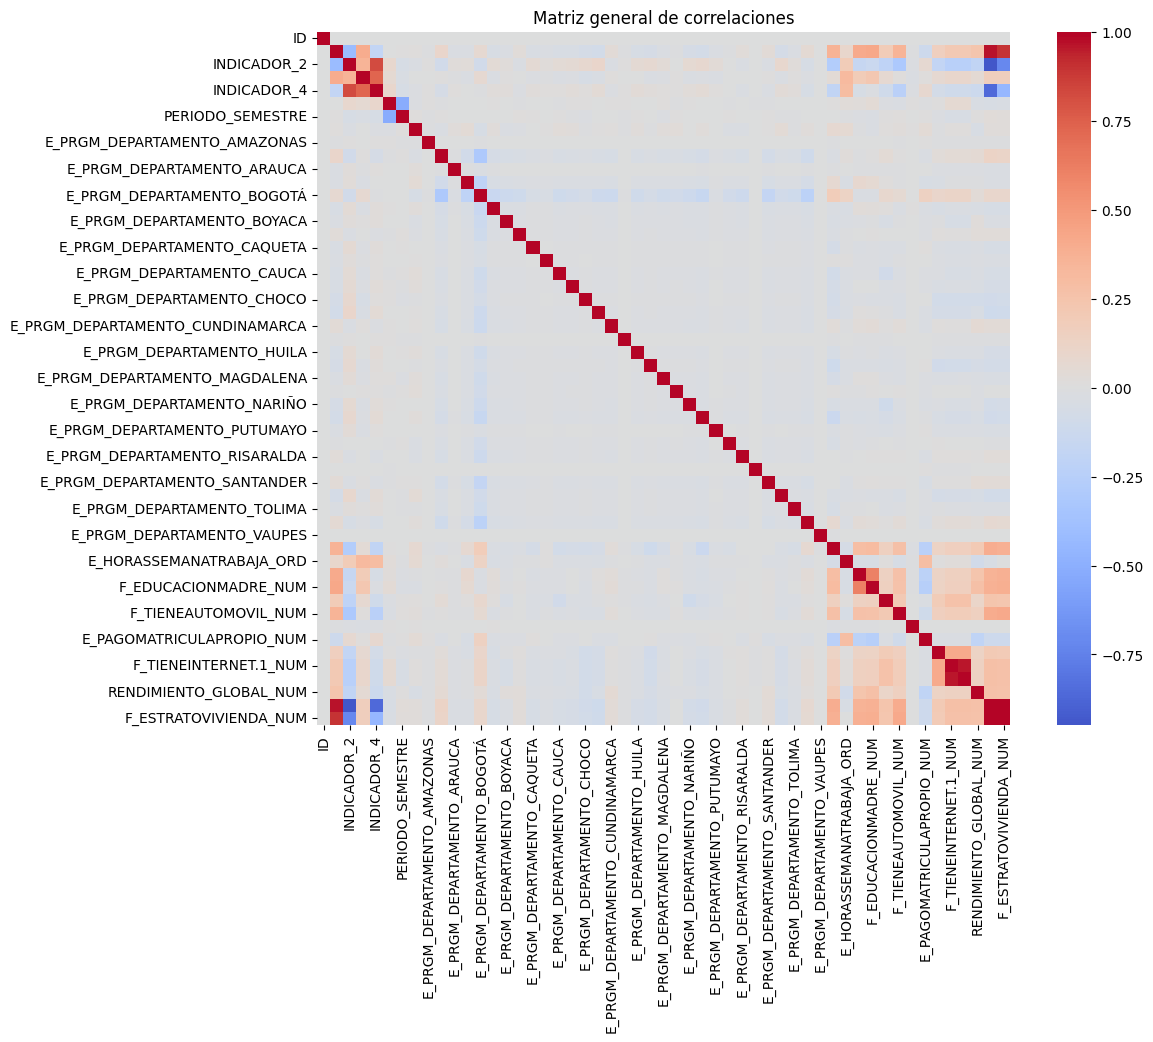

In [45]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True)
plt.title('Matriz general de correlaciones')
plt.show()

target = 'RENDIMIENTO_GLOBAL_NUM'
corr_target = corr[target].sort_values(ascending=False)


In [46]:
df.select_dtypes(include=['int64', 'float64']).columns.tolist()

['ID',
 'INDICADOR_1',
 'INDICADOR_2',
 'INDICADOR_3',
 'INDICADOR_4',
 'PERIODO_YEAR',
 'PERIODO_SEMESTRE',
 'E_PRGM_ACADEMICO_FE',
 'E_PRGM_DEPARTAMENTO_AMAZONAS',
 'E_PRGM_DEPARTAMENTO_ANTIOQUIA',
 'E_PRGM_DEPARTAMENTO_ARAUCA',
 'E_PRGM_DEPARTAMENTO_ATLANTICO',
 'E_PRGM_DEPARTAMENTO_BOGOTÁ',
 'E_PRGM_DEPARTAMENTO_BOLIVAR',
 'E_PRGM_DEPARTAMENTO_BOYACA',
 'E_PRGM_DEPARTAMENTO_CALDAS',
 'E_PRGM_DEPARTAMENTO_CAQUETA',
 'E_PRGM_DEPARTAMENTO_CASANARE',
 'E_PRGM_DEPARTAMENTO_CAUCA',
 'E_PRGM_DEPARTAMENTO_CESAR',
 'E_PRGM_DEPARTAMENTO_CHOCO',
 'E_PRGM_DEPARTAMENTO_CORDOBA',
 'E_PRGM_DEPARTAMENTO_CUNDINAMARCA',
 'E_PRGM_DEPARTAMENTO_GUAVIARE',
 'E_PRGM_DEPARTAMENTO_HUILA',
 'E_PRGM_DEPARTAMENTO_LA GUAJIRA',
 'E_PRGM_DEPARTAMENTO_MAGDALENA',
 'E_PRGM_DEPARTAMENTO_META',
 'E_PRGM_DEPARTAMENTO_NARIÑO',
 'E_PRGM_DEPARTAMENTO_NORTE SANTANDER',
 'E_PRGM_DEPARTAMENTO_PUTUMAYO',
 'E_PRGM_DEPARTAMENTO_QUINDIO',
 'E_PRGM_DEPARTAMENTO_RISARALDA',
 'E_PRGM_DEPARTAMENTO_SAN ANDRES',
 'E_PRGM_DEPARTAMENT

In [47]:
df.to_csv("cleaned_dataset.csv", index=False)